# Facial Emotion Recognition | VGG19 Model - FER2013 Dataset

In [1]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


## Library

In [1]:
import math
import numpy as np
import pandas as pd

import cv2
import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

In [2]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [7]:
# Filtrer les lignes où l'émotion est égale à 1 (disgust)
df = df[df.emotion != 1]

In [8]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

In [9]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
Name: emotion, dtype: int64

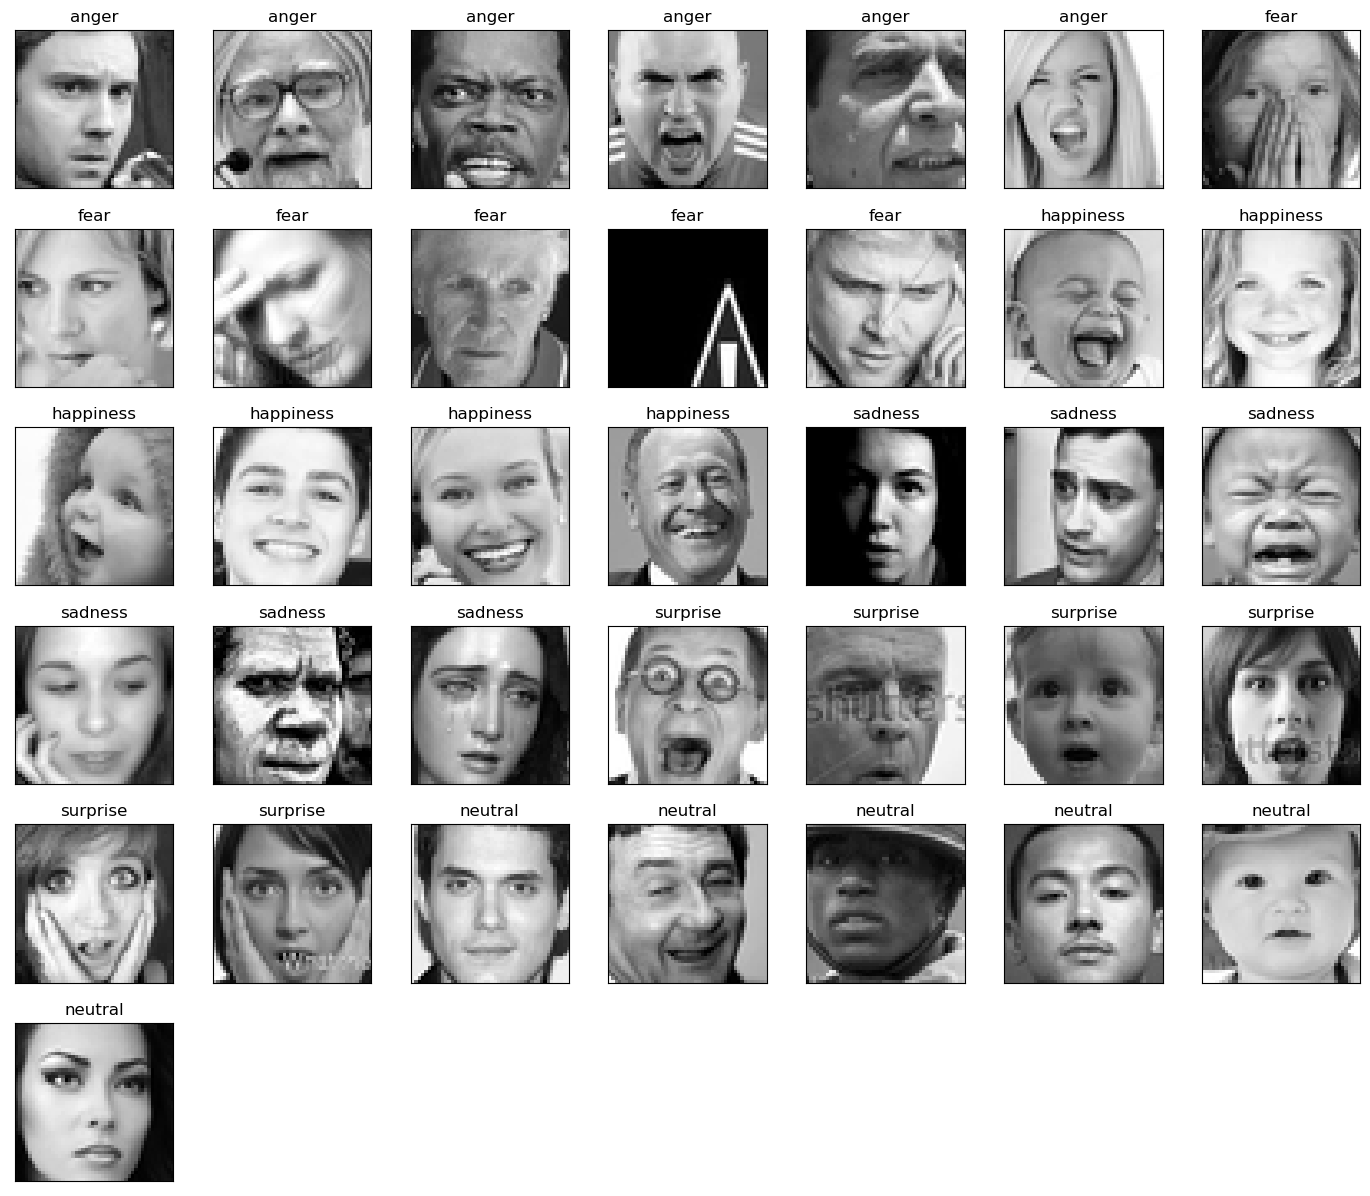

In [10]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(6):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

### Now I will make the data compatible for neural networks.

In [11]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [12]:
img_array.shape

(35340, 48, 48)

In [13]:
img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35340, 48, 48, 3)


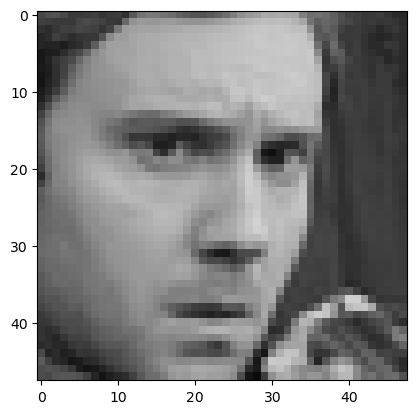

In [14]:
pyplot.imshow(img_features[0].astype(np.uint8));

In [15]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)  
img_labels = np_utils.to_categorical(img_labels)


In [16]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


### Splitting the data into training and validation set.

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((31806, 48, 48, 3), (3534, 48, 48, 3), (31806, 6), (3534, 6))

In [17]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

### Normalizing results, as neural networks are very sensitive to unnormalized data.

In [18]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2

vgg = tf.keras.applications.VGG19(weights='imagenet',
                                  include_top=False,
                                  input_shape=(48, 48, 3))

def build_model(bottom_model, classes):
    x = bottom_model.layers[-2].output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  
    x = Dense(classes, 
              activation='softmax', 
              name='out_layer',
              kernel_regularizer=l2(0.02))(x)  
    return x
    
num_classes = len(np.unique(df.emotion))  

head = build_model(vgg, num_classes)
model = Model(inputs=vgg.input, outputs=head)

print(model.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

### I used two callbacks one is `early stopping` for avoiding overfitting training data and other `ReduceLROnPlateau` for learning rate.


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

checkpoint = ModelCheckpoint(
    filepath='vgg_high.h5',  
    monitor='val_loss',        
    save_best_only=True,       
    mode='min',              
    verbose=1
)


callbacks = [early_stopping,lr_scheduler,checkpoint]

### As the data in hand is less as compared to the task so ImageDataGenerator is good to go.

In [23]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

batch_size = 32 
epochs = 45
optims = [optimizers.Adam(learning_rate = 0.0001, 
                          beta_1 = 0.9, beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

history = model.fit(train_datagen.flow(X_train, 
                                       y_train, 
                                       batch_size = batch_size),
                                       validation_data = (X_valid, y_valid),
                                       steps_per_epoch = len(X_train) / batch_size,
                                       epochs = epochs,
                                       callbacks = callbacks,
                                       use_multiprocessing = True)

Epoch 1/45
993/993 [============================>.] - ETA: 0s - loss: 1.8685 - accuracy: 0.2477
Epoch 1: val_loss improved from inf to 1.78809, saving model to vgg_high.h5
993/993 [==============================] - 40s 34ms/step - loss: 1.8684 - accuracy: 0.2477 - val_loss: 1.7881 - val_accuracy: 0.2544 - lr: 1.0000e-04
Epoch 2/45
993/993 [============================>.] - ETA: 0s - loss: 1.7744 - accuracy: 0.2541
Epoch 2: val_loss improved from 1.78809 to 1.76129, saving model to vgg_high.h5
993/993 [==============================] - 33s 33ms/step - loss: 1.7743 - accuracy: 0.2542 - val_loss: 1.7613 - val_accuracy: 0.2544 - lr: 1.0000e-04
Epoch 3/45
993/993 [============================>.] - ETA: 0s - loss: 1.7231 - accuracy: 0.2706
Epoch 3: val_loss improved from 1.76129 to 1.56847, saving model to vgg_high.h5
993/993 [==============================] - 33s 33ms/step - loss: 1.7231 - accuracy: 0.2707 - val_loss: 1.5685 - val_accuracy: 0.3540 - lr: 1.0000e-04
Epoch 4/45
993/993 [======

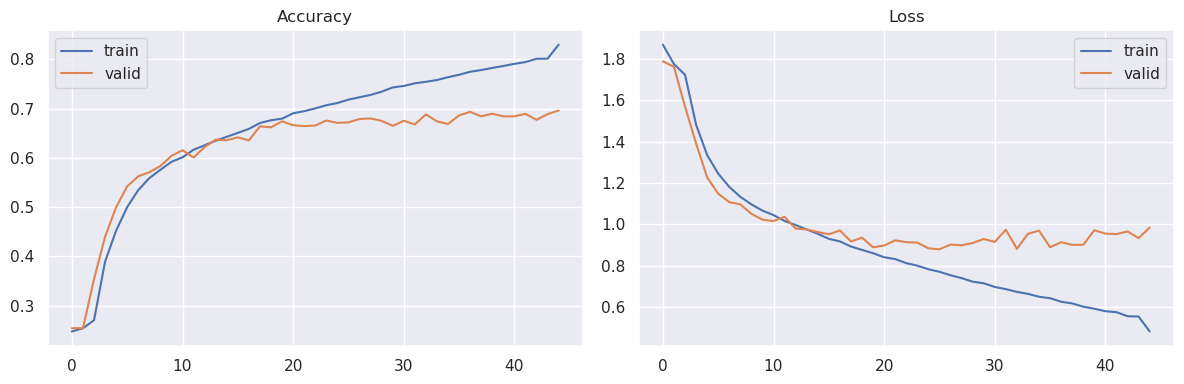

In [26]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()


In [97]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [98]:
model = load_model('/kaggle/working/vgg_high.h5') 

In [99]:
# 2. Vérification CRITIQUE avant fine-tuning
print("=== Vérification Obligatoire ===")
print(f"Shape sortie modèle: {model.output_shape}")  # Doit être (None, 6)
print(f"Shape y_train: {y_train.shape}")            # Doit être (None, 6)
print(f"Exemple label: {y_train[0]}")               # Doit être one-hot [0,0,1,0,0,0]


=== Vérification Obligatoire ===
Shape sortie modèle: (None, 6)
Shape y_train: (31806, 6)
Exemple label: [0. 1. 0. 0. 0. 0.]


In [100]:
# 3. Correction SI nécessaire (à décommenter si mismatch)
if model.output_shape[-1] != y_train.shape[-1]:
    print("\n Correction des shapes:")
    last_layer = model.layers[-1]
    new_layer = Dense(y_train.shape[-1], activation='softmax')(model.layers[-2].output)
    model = Model(inputs=model.input, outputs=new_layer)
    print(f"Nouvelle shape: {model.output_shape}")

In [101]:
# 4. Dégel STRATÉGIQUE (seulement les 3 derniers blocs)
for layer in model.layers:
    if 'block3' in layer.name or 'block4' in layer.name or 'block5' in layer.name:
        layer.trainable = True  # Dégel
        print(f"Dégel: {layer.name}")
    else:
        layer.trainable = False  # Gel

Dégel: block3_conv1
Dégel: block3_conv2
Dégel: block3_conv3
Dégel: block3_conv4
Dégel: block3_pool
Dégel: block4_conv1
Dégel: block4_conv2
Dégel: block4_conv3
Dégel: block4_conv4
Dégel: block4_pool
Dégel: block5_conv1
Dégel: block5_conv2
Dégel: block5_conv3
Dégel: block5_conv4


In [102]:
# 5. Recompilation NOUVELLE
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # LR 10x plus petit
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [103]:
checkpoint_path = "vgg_finetuned.h5"

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',  # Surveillance de la perte de validation
    mode='min',         # Mode minimisation pour la loss
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

In [104]:
# 6. Entraînement FINAL
history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train)//32,
    epochs=40,
    validation_data=(X_valid, y_valid),
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.2, patience=5),checkpoint_callback
    ]
)


Epoch 1/40
993/993 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.7469
Epoch 1: val_loss improved from inf to 0.88269, saving model to vgg_finetuned.h5
993/993 [==============================] - 33s 32ms/step - loss: 0.6907 - accuracy: 0.7469 - val_loss: 0.8827 - val_accuracy: 0.6842 - lr: 1.0000e-05
Epoch 2/40
993/993 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7565
Epoch 2: val_loss improved from 0.88269 to 0.87752, saving model to vgg_finetuned.h5
993/993 [==============================] - 31s 31ms/step - loss: 0.6703 - accuracy: 0.7565 - val_loss: 0.8775 - val_accuracy: 0.6870 - lr: 1.0000e-05
Epoch 3/40
993/993 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7605
Epoch 3: val_loss did not improve from 0.87752
993/993 [==============================] - 31s 31ms/step - loss: 0.6575 - accuracy: 0.7605 - val_loss: 0.8839 - val_accuracy: 0.6873 - lr: 1.0000e-05
Epoch 4/40
993/993 [=============================

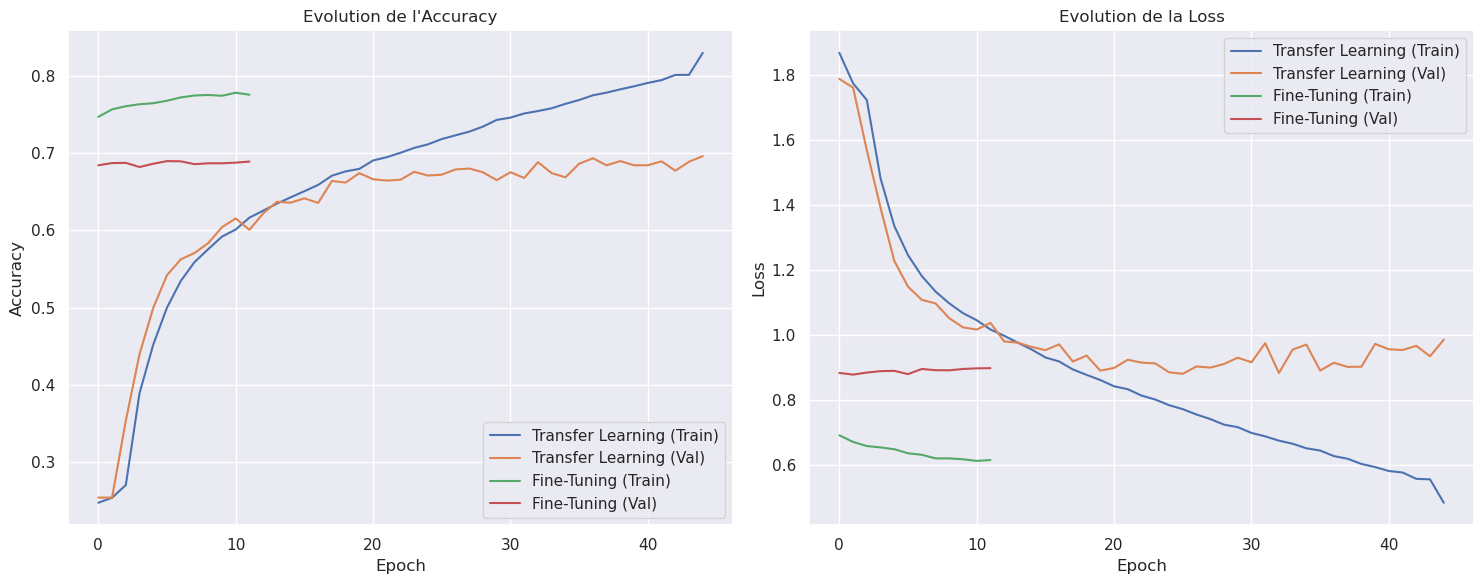


Comparaison des Performances:


,Phase,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,Transfer Learning,0.829623,0.696095,0.482965,0.879966
1,Fine-Tuning,0.778026,0.689587,0.611818,0.877523


In [106]:
# --- ANALYSE COMPARATIVE ---
import matplotlib.pyplot as plt
import pandas as pd

# 1. Préparation des données
transfer_history = pd.DataFrame(history.history)
fine_history = pd.DataFrame(history_fine.history)

# 2. Visualisation comparative
plt.figure(figsize=(15, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(transfer_history['accuracy'], label='Transfer Learning (Train)')
plt.plot(transfer_history['val_accuracy'], label='Transfer Learning (Val)')
plt.plot(fine_history['accuracy'], label='Fine-Tuning (Train)')
plt.plot(fine_history['val_accuracy'], label='Fine-Tuning (Val)')
plt.title('Evolution de l\'Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(transfer_history['loss'], label='Transfer Learning (Train)')
plt.plot(transfer_history['val_loss'], label='Transfer Learning (Val)')
plt.plot(fine_history['loss'], label='Fine-Tuning (Train)')
plt.plot(fine_history['val_loss'], label='Fine-Tuning (Val)')
plt.title('Evolution de la Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

# 3. Métriques finales
final_metrics = {
    'Phase': ['Transfer Learning', 'Fine-Tuning'],
    'Train Accuracy': [max(history.history['accuracy']), max(history_fine.history['accuracy'])],
    'Val Accuracy': [max(history.history['val_accuracy']), max(history_fine.history['val_accuracy'])],
    'Train Loss': [min(history.history['loss']), min(history_fine.history['loss'])],
    'Val Loss': [min(history.history['val_loss']), min(history_fine.history['val_loss'])]
}

metrics_df = pd.DataFrame(final_metrics)
print("\nComparaison des Performances:")
display(metrics_df.style.background_gradient(cmap='Blues'))


111/111 [==============================] - 1s 10ms/step
total wrong validation predictions: 1106


              precision    recall  f1-score   support

           0       0.62      0.66      0.64       495
           1       0.53      0.46      0.49       512
           2       0.87      0.88      0.87       899
           3       0.57      0.55      0.56       608
           4       0.81      0.74      0.77       400
           5       0.63      0.73      0.68       620

    accuracy                           0.69      3534
   macro avg       0.67      0.67      0.67      3534
weighted avg       0.69      0.69      0.69      3534



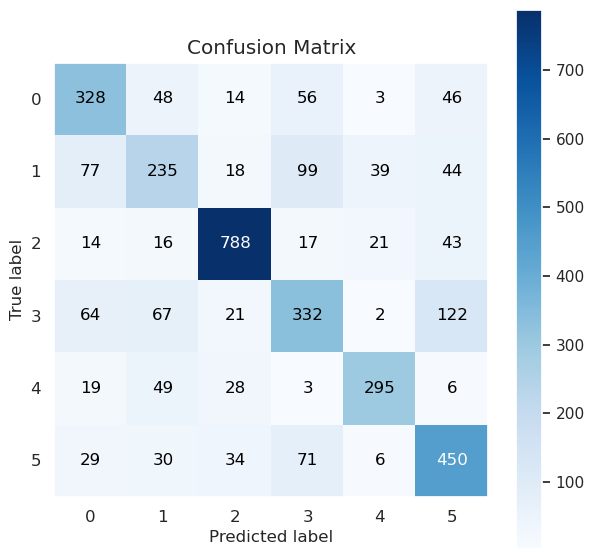

In [107]:
yhat_valid = np.argmax(model.predict(X_valid), axis=1)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

### The confusion matrix clearly shows that our model is doing good job on the class happy but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

 # **Explainable AI for CNN Multiclassification**

In this section, we will explore two popular Explainable AI (XAI) frameworks, LIME (Local Interpretable Model-agnostic Explanations) and SHAP (SHapley Additive exPlanations), to interpret the predictions of our CNN multiclass model .

## LIME for Model Interpretation

LIME explains the predictions of any classifier by learning an interpretable model locally around each prediction. For image classification, LIME perturbs the input image and observes how the model's predictions change.

We'll use LIME to generate explanations for a sample prediction.

In [17]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
import os

In [18]:
model = load_model('/kaggle/input/vgg19/tensorflow2/default/1/vgg_high.h5')

 Preprocess images

In [19]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_features = []
for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)
img_features = np.array(img_features) / 255.0  

In [29]:
sample_image = (img_features[10] * 255).astype('uint8') 

In [30]:
explainer = lime_image.LimeImageExplainer()

In [31]:
explanation = explainer.explain_instance(
    sample_image,  
    model.predict,  
    top_labels=6,  
    hide_color=0,  
    num_samples=1000  
)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


In [32]:
top_class = np.argmax(model.predict(sample_image.reshape(1, 48, 48, 3)))
temp, mask = explanation.get_image_and_mask(
    label=top_class,
    positive_only=False,
    hide_rest=False,
    num_features=10
)

1/1 [==============================] - 0s 21ms/step


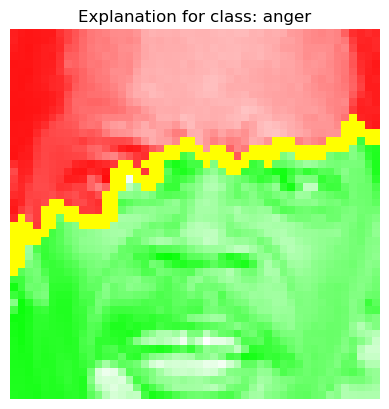

In [33]:
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f"Explanation for class: {emotion_label_to_text[top_class]}")
plt.axis('off')
plt.show()

**Interpretation of the prediction with LIME**

The image above shows a local explanation generated by LIME for the prediction of the "anger" class. 
The highlighted superpixels (outlined regions) indicate the parts of the image that contributed the most to the model’s decision. In this case, areas around the eyes and forehead were most influential in classifying the emotion as anger.

Note that the background colors (green, red, etc.) come from the original image and the overlay, and do not directly represent the importance or weight of the features. Only the outlined regions are relevant in the LIME explanation, as they show which parts of the input the model relied on the most to make its prediction.

## SHAP for Model Interpretation

SHAP assigns each feature an importance value for a particular prediction. For deep learning models like CNNs, SHAP uses DeepExplainer or GradientExplainer to compute Shapley values.

In [17]:
import shap
import numpy as np

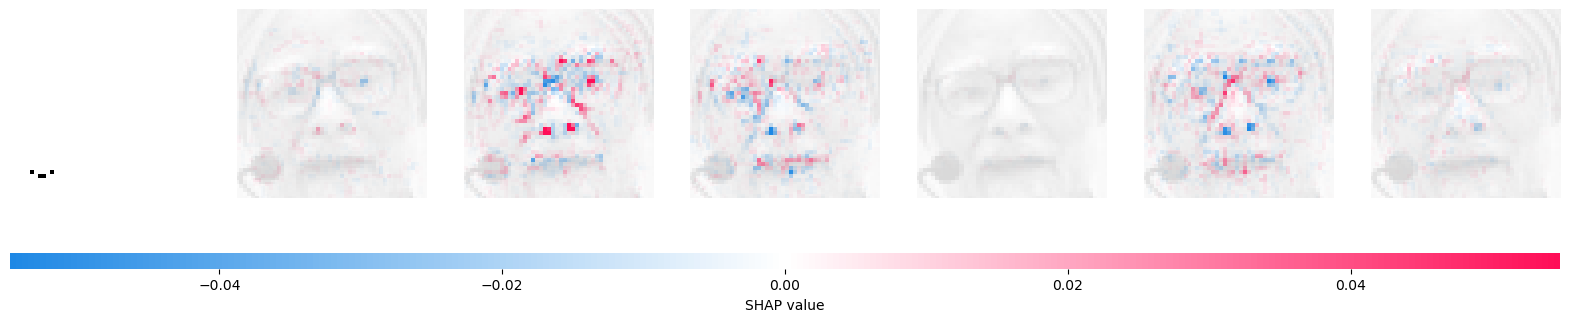

In [33]:
background = img_features[:90].astype(np.float32)  
sample_input = sample_image.reshape(1, 48, 48, 3).astype(np.float32)

explainer = shap.GradientExplainer(model, background)

shap_values = explainer.shap_values(sample_input)

shap.image_plot(shap_values, sample_input)


**Interpretation with SHAP**

In this section, we used SHAP (SHapley Additive exPlanations) to interpret the decisions made by our convolutional neural network (CNN) model, which performs image classification across six different classes. 

SHAP is a model-agnostic explainability tool that computes the contribution of each feature—in this case, each pixel in the image—to the model's output.

We used a background dataset composed of the first 90 images from our dataset to help SHAP understand the general behavior of the model.

A specific input image was then passed through the GradientExplainer, which calculated SHAP values indicating how much each pixel contributed to increasing or decreasing the prediction confidence for each class. 
The shap.image_plot() function visualizes this by generating a series of heatmaps—one for each class—where red areas represent positive contributions and blue areas represent negative ones.

These visualizations provide insights into which regions of the image the model is focusing on when predicting a particular class. For instance, if a certain region is consistently highlighted in red for a class, it suggests that this area contains features that the model strongly associates with that class. 

This interpretability step is essential for validating model behavior, building trust, and ensuring fairness, especially in multi-class classification problems.